In [1]:
import numpy as np
import matplotlib.pyplot as plt
import taichi as ti


[Taichi] version 1.3.0, llvm 15.0.1, commit 0f25b95e, win, python 3.10.9


In [2]:
# KNAPSACK_01 Data for the 01 Knapsack Problem
# P-08 24 elements
capacity = 6404180
optimal = np.asarray([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
                     1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1])

weights = np.asarray([382745, 799601, 909247, 729069, 467902, 44328, 34610, 698150,
                      823460, 903959, 853665, 551830, 610856, 670702, 488960, 951111, 323046, 446298, 931161,
                      31385, 496951, 264724, 224916, 169684])

profits = np.asarray([825594, 1677009, 1676628, 1523970, 943972, 97426, 69666, 1296457,
                      1679693, 1902996, 1844992, 1049289, 1252836, 1319836, 953277, 2067538, 675367, 853655,
                      1826027, 65731, 901489, 577243, 466257, 369261])


In [3]:
print("Total possible configurations - ", 2**24)

Total possible configurations -  16777216


In [4]:
optimal_weight = 0
optimal_profit = 0
for i in range(optimal.shape[0]):
    if optimal[i] == 1:
        optimal_weight += weights[i]
        optimal_profit += profits[i]
print("Optimal profit - {}, with weight - {}".format(optimal_profit, optimal_weight))

Optimal profit - 13549094, with weight - 6402560


In [5]:
from Knapsack import KnapsackSettings
from Knapsack import Knapsack
from KnapsackTaichi import KnapsackTaichi

settings = KnapsackSettings(population_size=1_000, num_objects=weights.shape[0], profits=profits, weights=weights,
                            capacity=capacity, iterations=10_000, mutation_rate=0.1, elitism_num=25)


In [6]:
ti.profiler.clear_kernel_profiler_info()  # clear all records
k = KnapsackTaichi(settings=settings, architecture=ti.cpu, max_num_threads=12)
k.advance()
ti.profiler.print_kernel_profiler_info(mode='count')

[Taichi] Starting on arch=x64
Kernel Profiler(count, default) @ X64 
[      %     total   count |      min       avg       max   ] Kernel name
-------------------------------------------------------------------------
[ 99.94%   0.198 s      1x |  198.411   198.411   198.411 ms] advance_c78_0_kernel_0_serial
[  0.05%   0.000 s      1x |    0.105     0.105     0.105 ms] randomize_population_c76_4_kernel_0_range_for
[  0.00%   0.000 s     43x |    0.000     0.000     0.001 ms] jit_evaluator_0_kernel_0_serial
[  0.00%   0.000 s     24x |    0.000     0.000     0.002 ms] snode_writer_16_kernel_0_serial
[  0.00%   0.000 s     24x |    0.000     0.000     0.001 ms] snode_writer_18_kernel_0_serial
[  0.00%   0.000 s      2x |    0.000     0.000     0.000 ms] jit_evaluator_1_kernel_0_serial
[  0.00%   0.000 s      4x |    0.000     0.000     0.000 ms] jit_evaluator_2_kernel_0_serial
[  0.00%   0.000 s      1x |    0.000     0.000     0.000 ms] jit_evaluator_3_kernel_0_serial
[  0.00%   0.000 s 

Text(0, 0.5, 'Profit')

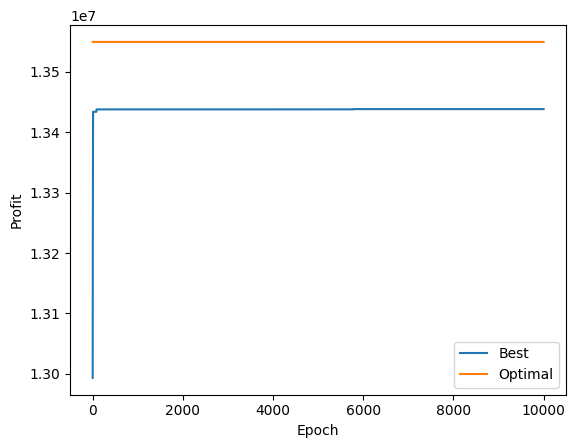

In [7]:
plt.plot(k.best, label="Best")
plt.plot(np.full(settings.iterations, fill_value=optimal_profit), label="Optimal")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Profit")


Text(0, 0.5, 'Profit')

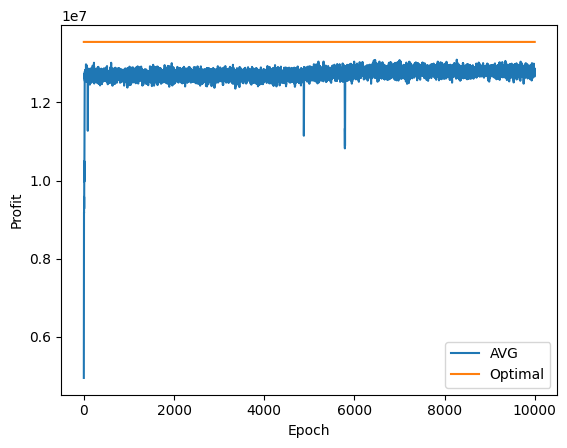

In [8]:
plt.plot(k.avg, label="AVG")
plt.plot(np.full(settings.iterations, fill_value=optimal_profit), label="Optimal")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Profit")


In [9]:
import time

settings = KnapsackSettings(population_size=500, num_objects=weights.shape[0], profits=profits, weights=weights,
                            capacity=capacity, iterations=100, mutation_rate=0.1, elitism_num=25)
                            

def measure_time(di, arch, threads=12) -> list[float]:
    dt = []
    for i in range(len(di)):
        settings.iterations = di[i]
        start = time.time()
        if arch != None:
            k = KnapsackTaichi(settings=settings,
                               architecture=arch, max_num_threads=threads)
        else:
            k = Knapsack(settings=settings)
        k.advance()
        dt.append(time.time() - start)
    return dt


def iterations_per_second(iterations, time) -> float:
    dt = 0
    di = 0
    for i in range(len(iterations) - 1):
        dt += time[i + 1] - time[i]
        di += iterations[i + 1] - iterations[i]
    return di / dt


In [10]:
iters = [n*100 for n in range(1, 4)]
py_perf = measure_time(iters, None)
py_ips = iterations_per_second(iters, py_perf)

# improve accuracy by increasing the epochs count
iters_x = [n*1_000 for n in range(1, 4)]
ti_gpu_perf = measure_time(iters_x, ti.gpu)
ti_gpu_ips = iterations_per_second(iters_x, ti_gpu_perf)

iters_xl = [n*1_000 for n in range(1, 4)]
ti_cpu_perf = measure_time(iters_xl, ti.cpu)
ti_cpu_ips = iterations_per_second(iters_xl, ti_cpu_perf)


[Taichi] Starting on arch=cuda
[Taichi] Starting on arch=cuda
[Taichi] Starting on arch=cuda
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64


In [14]:
data = {'Python': py_ips, 'Taichi GPU': ti_gpu_ips, 'Taichi CPU': ti_cpu_ips}
for key in data:
    print("{} - {:.2f} iterations (epochs) per second".format(key, data[key]))
print()

for key in data:
    print("{} - {:.2f}x faster".format(key, data[key] / py_ips))


Python - 33.60 iterations (epochs) per second
Taichi GPU - 474.99 iterations (epochs) per second
Taichi CPU - 24424.75 iterations (epochs) per second

Python - 1.00x faster
Taichi GPU - 14.14x faster
Taichi CPU - 726.95x faster
